In [70]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [71]:
!pip install tensorflow-privacy -q

In [72]:
# pip install -U TensorFlow-privacy

In [73]:
# !pip install tensorflow_privacy

In [74]:
!pip install keras-tuner --upgrade --q

In [75]:
import os
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
     auc,
)

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from sklearn.model_selection import StratifiedKFold


#Filtering errors
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Process Data

In [77]:
data  = pd.read_csv('/content/drive/MyDrive/IoT_Intrusion.csv')

In [78]:
# Multiclass problem
target_column = 'label'
display(data[target_column].unique())
num_classes = data[target_column].nunique()

array(['DDoS-RSTFINFlood', 'DoS-TCP_Flood', 'DDoS-ICMP_Flood',
       'DoS-UDP_Flood', 'DoS-SYN_Flood', 'Mirai-greeth_flood',
       'DDoS-SynonymousIP_Flood', 'Mirai-udpplain', 'DDoS-SYN_Flood',
       'DDoS-PSHACK_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood',
       'BenignTraffic', 'MITM-ArpSpoofing', 'DDoS-ACK_Fragmentation',
       'Mirai-greip_flood', 'DoS-HTTP_Flood', 'DDoS-ICMP_Fragmentation',
       'Recon-PortScan', 'DNS_Spoofing', 'DDoS-UDP_Fragmentation',
       'Recon-OSScan', 'XSS', 'DDoS-HTTP_Flood', 'Recon-HostDiscovery',
       'CommandInjection', 'VulnerabilityScan', 'DDoS-SlowLoris',
       'Backdoor_Malware', 'BrowserHijacking', 'DictionaryBruteForce',
       'SqlInjection', 'Recon-PingSweep', 'Uploading_Attack'],
      dtype=object)

In [79]:
# simplify the problem lets only predict for top 3 conditions
data = data[data[target_column].isin(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood'])]

In [80]:
# Label encode the target column
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column
data[target_column] = label_encoder.fit_transform(data[target_column])

<ipython-input-80-682360964b40>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[target_column] = label_encoder.fit_transform(data[target_column])


In [81]:
# Identify non-numeric columns (there are none)
print(data.select_dtypes(include='object').columns)

Index([], dtype='object')


In [82]:
categorical_columns = [col for col in data.columns if col not in [target_column]] # Other columns

X = data.drop(target_column, axis=1)
y = data[target_column]

# Split into training test and validation datasets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

# Reshape data for LSTM

#I now convert the scaled training set into a NP Arrays and then reshape it

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

X_valid_array = X_valid_scaled[categorical_columns].to_numpy()

X_valid_reshaped = X_valid_array.reshape(X_valid_array.shape[0], 1, X_valid_array.shape[1])

## Hyper Tune

In [83]:
# !pip install keras-tuner --upgrade --q

In [84]:
# import keras_tuner as kt

In [85]:
# # Build hypertunable model (adjust number of nodes, number of layers, learning rate, optimizer and dropout)
# def build_lstm_model(hp):
#     model = Sequential()
#     model.add(LSTM(units=hp.Int('units', min_value=8, max_value=64, step=8),
#                    input_shape=((1, len(categorical_columns)))))

#     for i in range(hp.Int('num_layers', 1, 3)):  # Tunable number of Dense layers
#         model.add(Dense(units=hp.Int(f'units_{i}', min_value=8, max_value=64, step=8)))

#     model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
#     model.add(Dense(num_classes, activation='softmax'))

#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

#     if hp_optimizer == 'adam':
#         optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
#     else:
#         optimizer = SGD(learning_rate=hp_learning_rate)

#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model

In [86]:
#tuner = kt.RandomSearch(build_model,
                        #objective='val_loss',
                        #max_trials=100) # Change max trials to 100 for the full experiment
#tuner = kt.RandomSearch(build_lstm_model,
 #                     objective='val_loss',
 #                     max_trials=100)

#tuner.search(X_train_lstm, y_train, epochs=50, validation_data=(X_valid_reshaped , y_valid)) # Change Epochs as well
#best_model = tuner.get_best_models()[0]

In [87]:
# SAVE THIS
#best_model.summary()
#model.summary()
#print(best_model.summary())

## LSTM Default

In [88]:
from keras.callbacks import EarlyStopping
# Early stopping (make patience bigger if stopping too early)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [89]:
# Define the input_shape variable
#input_shape = X_train_lstm.shape[1:]
input_shape=(1, len(categorical_columns))

# Create a simpler LSTM model with a smaller number of units and dropout
model = Sequential()
model.add(LSTM(units=48, input_shape=input_shape))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=48, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Perform 6-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on this fold
    model_history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    cv_results.append((val_loss, val_accuracy))

# Fit on full data
model_history = model.fit(X_train_lstm, y_train, epochs=30, batch_size=128, validation_split = 0.2, callbacks=[early_stopping])

# Predict on the test data
X_test_array = X_test_scaled[categorical_columns].to_numpy()
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

y_test_pred = model.predict(X_test_reshaped)

Epoch 1/30
1874/1874 [==============================] - 12s 5ms/step - loss: 0.5839 - accuracy: 0.9785 - val_loss: 0.0068 - val_accuracy: 0.9985
Epoch 2/30
1874/1874 [==============================] - 8s 4ms/step - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 3/30
1874/1874 [==============================] - 8s 4ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0024 - val_accuracy: 0.9991
Epoch 4/30
1874/1874 [==============================] - 8s 4ms/step - loss: 0.0023 - accuracy: 0.9991 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 5/30
1874/1874 [==============================] - 8s 4ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 6/30
1874/1874 [==============================] - 7s 4ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 0.9993
Epoch 7/30
1874/1874 [==============================] - 8s 4ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy

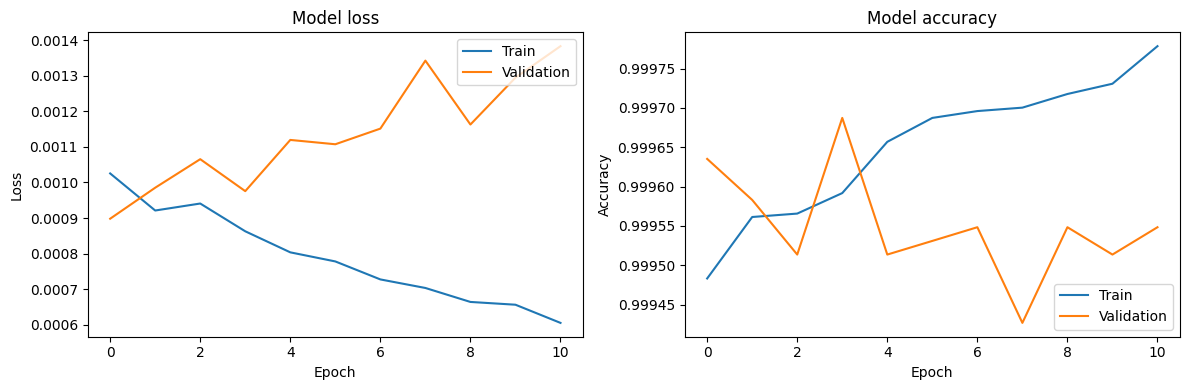

In [90]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot loss curves
plot_loss(model_history)

In [91]:
# Convert probability predictions to class labels
y_test_pred_classes_mlp = np.argmax(y_test_pred, axis=1)

# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp = accuracy_score(y_test, y_test_pred_classes_mlp)
precision_mlp = precision_score(y_test, y_test_pred_classes_mlp, average='macro')
recall_mlp = recall_score(y_test, y_test_pred_classes_mlp, average='macro')
f1_mlp = f1_score(y_test, y_test_pred_classes_mlp, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp}")
print(f"Precision = {precision_mlp}")
print(f"Recall = {recall_mlp}")
print(f"F1 Score =  {f1_mlp}")

Average cross-validation loss: 0.001193044406439488
Average cross-validation accuracy: 0.999454547961553
MLP Model:
Accuracy =  0.9995049246964407
Precision = 0.9995192775099656
Recall = 0.9994833442562164
F1 Score =  0.9995012705091186


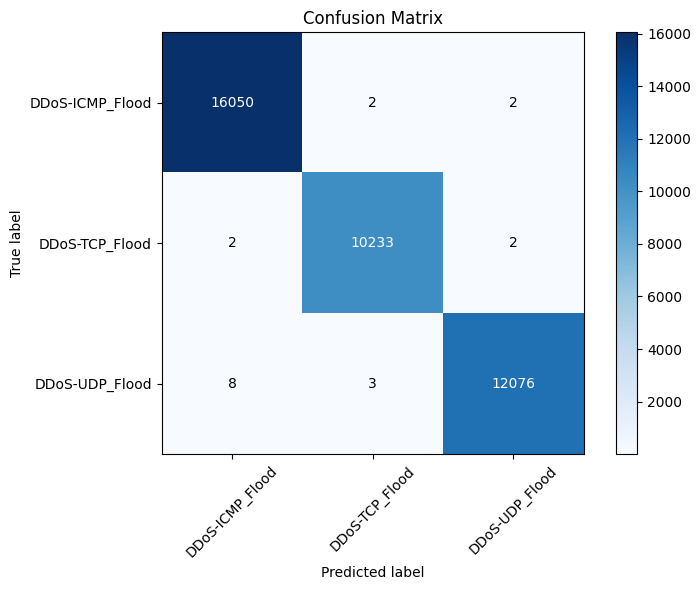

In [92]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes_mlp)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

## Privacy

In [93]:
# Set hyperparameters for privacy-preserving training
batch_size = 128  # Number of samples in each training batch
l2_norm_clip = 1.5  # Upper bound on the L2 norm of model's gradients
noise_multiplier = 1.3  # Multiplier for the Gaussian noise added to gradients
num_microbatches = 128  # Number of microbatches for training
learning_rate = 0.003  # Learning rate for the optimizer

# Ensure that batch size is a multiple of the number of microbatches
if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

# Initialize a differentially private stochastic gradient descent optimizer
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# Define the loss function for the model
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [94]:
input_shape=(1, len(categorical_columns))

# Create a simpler LSTM model with a smaller number of units and dropout
model_privacy = Sequential()
model_privacy.add(LSTM(units=48, input_shape=input_shape))
model_privacy.add(Dense(units=64, activation='relu'))
model_privacy.add(Dense(units=48, activation='relu'))
model_privacy.add(Dropout(rate=0.1))
model_privacy.add(Dense(num_classes, activation='softmax'))

In [95]:
# # Reshape the data to fit the model input
# X_train_lstm_trimmed = X_train_lstm_trimmed.reshape(
#     (X_train_lstm_trimmed.shape[0], X_train_lstm_trimmed.shape[2], 1))
# X_valid_reshaped_trimmed = X_valid_reshaped_trimmed.reshape(
#     (X_valid_reshaped_trimmed.shape[0], X_valid_reshaped_trimmed.shape[2], 1))

In [96]:
# Compile the model outside the loop if the architecture and optimizer are consistent
model_privacy.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform 5-fold cross-validation
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kfold.split(X_train_lstm, y_train):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Reshape labels to be logtis (see shape check below)
    y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=num_classes)
    y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=num_classes)

    # Need to reshape data to batch divisilbe size
    new_size = (X_train_fold.shape[0] // batch_size) * batch_size
    X_train_lstm_trimmed = X_train_fold[:new_size]
    y_train2 = y_train_fold2[:new_size]

    new_size = (X_val_fold.shape[0] // batch_size) * batch_size
    X_valid_reshaped_trimmed = X_val_fold[:new_size]
    y_valid2 = y_val_fold2[:new_size]

    # Train the model on this fold
    model_history_privacy = model_privacy.fit(
        X_train_lstm_trimmed , y_train2, epochs=30, batch_size=batch_size,validation_data=(X_valid_reshaped_trimmed , y_valid2),
        callbacks=[early_stopping])

    # Evaluate on the validation set
    val_loss, val_accuracy = model_privacy.evaluate(X_valid_reshaped_trimmed , y_valid2)
    cv_results.append((val_loss, val_accuracy))

# Fit model on full data
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
new_size = (X_train_lstm.shape[0] // batch_size) * batch_size
model_history_privacy = model_privacy.fit(
        X_train_lstm[:new_size], y_train_cat[:new_size], epochs=30, batch_size=batch_size,validation_data=(X_valid_reshaped_trimmed , y_valid2),
        callbacks=[early_stopping])

Epoch 1/30
1873/1873 [==============================] - 74s 36ms/step - loss: 0.6817 - accuracy: 0.9412 - val_loss: 0.2396 - val_accuracy: 0.9962
Epoch 2/30
1873/1873 [==============================] - 66s 35ms/step - loss: 0.1015 - accuracy: 0.9960 - val_loss: 0.0371 - val_accuracy: 0.9958
Epoch 3/30
1873/1873 [==============================] - 66s 35ms/step - loss: 0.0297 - accuracy: 0.9961 - val_loss: 0.0193 - val_accuracy: 0.9961
Epoch 4/30
1873/1873 [==============================] - 66s 35ms/step - loss: 0.0192 - accuracy: 0.9964 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 5/30
1873/1873 [==============================] - 66s 35ms/step - loss: 0.0154 - accuracy: 0.9966 - val_loss: 0.0125 - val_accuracy: 0.9965
Epoch 6/30
1873/1873 [==============================] - 67s 36ms/step - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0113 - val_accuracy: 0.9967
Epoch 7/30
1873/1873 [==============================] - 66s 35ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0104 -

In [97]:
# Predict on the test data
y_test_pred_mlp_privacy = model_privacy.predict(X_test_reshaped)

# # Apply the threshold to make binary predictions
y_test_pred_binary_mlp_privacy = y_test_pred_mlp_privacy.argmax(axis=1)

1200/1200 [==============================] - 3s 2ms/step


In [98]:
# Print the average cross-validation results
print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_mlp_privacy = accuracy_score(y_test, y_test_pred_binary_mlp_privacy)
precision_mlp_privacy = precision_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
recall_mlp_privacy = recall_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')
f1_mlp_privacy = f1_score(y_test, y_test_pred_binary_mlp_privacy, average='macro')

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_mlp_privacy}")
print(f"Precision = {precision_mlp_privacy}")
print(f"Recall = {recall_mlp_privacy}")
print(f"F1 Score =  {f1_mlp_privacy}")

Average cross-validation loss: 0.0046904619472722215
Average cross-validation accuracy: 0.99886155128479
MLP Model:
Accuracy =  0.9991661889624264
Precision = 0.9991074814024795
Recall = 0.9992052851386414
F1 Score =  0.9991563132442233


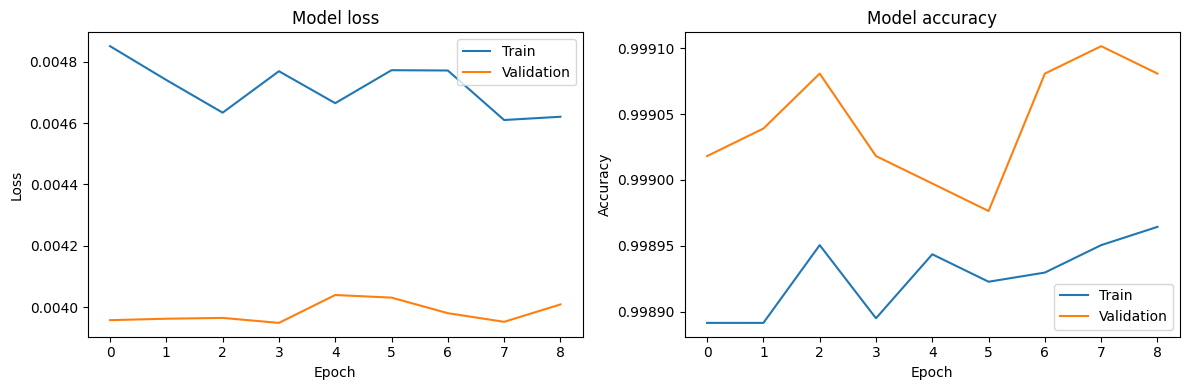

In [99]:
# Plot loss curves
plot_loss(model_history_privacy)

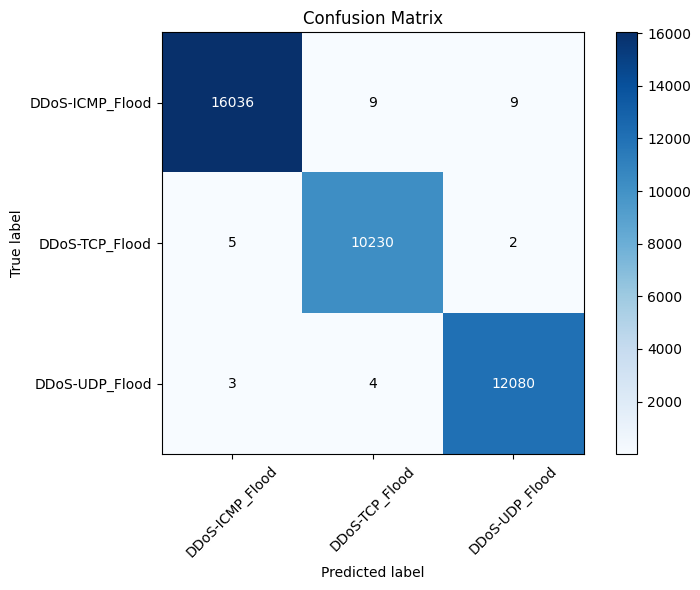

In [100]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary_mlp_privacy)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = conf_matrix.shape[0]

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

plt.xticks(np.arange(num_classes), class_labels, rotation=45)
plt.yticks(np.arange(num_classes), class_labels)

thresh = conf_matrix.max() / 2.

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [101]:
# Compute privacy budget#compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_lstm_trimmed),
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    num_epochs=30,
    delta=1e-5
)

In [102]:
print(privacy_report)

DP-SGD performed over 239744 examples with 128 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      2.526

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



## Combine Results

In [103]:
# Create DataFrame
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Regular': [accuracy_mlp, precision_mlp, recall_mlp, f1_mlp],
    'Privacy': [accuracy_mlp_privacy, precision_mlp_privacy, recall_mlp_privacy, f1_mlp_privacy]
}

df = pd.DataFrame(data)

# Print DataFrame
display(df)

,Metric,Regular,Privacy
0,Accuracy,0.999505,0.999166
1,Precision,0.999519,0.999107
2,Recall,0.999483,0.999205
3,F1 Score,0.999501,0.999156


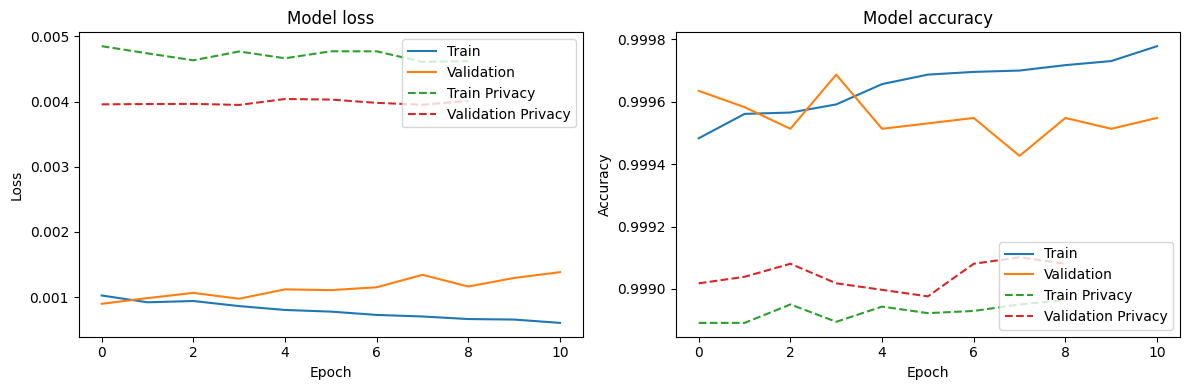

In [104]:
plot_loss(model_history, model_history_privacy)